# Analiza Portfelowa Metodą Markowitza

Program ładuje wszystkie pliki CSV zawierające metryki z notowań historycznych wybranych spółek pobranych z portalu stooq.pl. 

**Istotne jest to, aby wszystkie notowania historyczne były z tego samego zakresu dat**

Najłatwiejszym sposobem pobrania notowań dla kolejnych spółek jest wejście w poniszy link, zmieniają uprzednio ticker spółki

`https://stooq.pl/q/d/?s=<wstaw swoj ticker spółki>&c=0&d1=19991126&d2=20240320`

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy.optimize import minimize

# Ścieżka do folderu z plikami CSV
folder_path = 'stocks'

# Inicjalizacja pustego DataFrame, który będzie bazą do scalenia
merged_df = None

# Iteracja przez pliki w folderze
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Ścieżka do pliku
        file_path = os.path.join(folder_path, filename)
        
        # Wczytanie danych z pliku CSV
        df = pd.read_csv(file_path)
        
        # Ekstrakcja nazwy spółki z nazwy pliku (bez rozszerzenia .csv)
        company_name = filename[:-4]  # Usunięcie '.csv'
        
        # Zmiana nazwy kolumny 'Zamkniecie' na 'Zamkniecie <nazwa spółki>'
        df.rename(columns={'Zamkniecie': f'Zamkniecie_{company_name}'}, inplace=True)
        
        # Selekcja kolumn 'Data' i zmienionej 'Zamkniecie <nazwa spółki>'
        df = df[['Data', f'Zamkniecie_{company_name}']]
        
        if merged_df is None:
            # Pierwszy DataFrame, który inicjalizuje merged_df
            merged_df = df
        else:
            # Scalanie z kolejnymi DataFrame'ami po dacie, zachowując wszystkie daty
            merged_df = pd.merge(merged_df, df, on='Data', how='outer')

# Sortowanie danych po dacie
merged_df.sort_values('Data', inplace=True)

# Resetowanie indeksu
merged_df.reset_index(drop=True, inplace=True)

# Przykładowe wyświetlenie danych
print(merged_df.head())


         Data  Zamkniecie_kety  Zamkniecie_kghm  Zamkniecie_orlen
0  1999-11-26          16.6843          7.68468           13.3511
1  1999-11-29          16.4202          7.62286           13.1130
2  1999-11-30          16.8402          7.75123           13.3511
3  1999-12-01          16.9519          8.04734           13.7729
4  1999-12-02          16.8402          7.88363           14.0189


Powyzszy kod:
1. załadował nasze pliki CSV
2. wyciągnął interesujące nas kolumny tj. `Data`, `Zamkniecie` które reprezentują date oraz wartość akcji na zamknięciu
3. Utworzył nowy `dataframe` dla pierwszego notowania, a juz kolejne dopisywał do juz istniejacego `dataframe`

Wynikiem powyzszych operacji jest tabela, na której mozemy operowac w celu dokonania analizy portfelowej

In [2]:
merged_df

,Data,Zamkniecie_kety,Zamkniecie_kghm,Zamkniecie_orlen
0,1999-11-26,16.6843,7.68468,13.3511
1,1999-11-29,16.4202,7.62286,13.1130
2,1999-11-30,16.8402,7.75123,13.3511
3,1999-12-01,16.9519,8.04734,13.7729
4,1999-12-02,16.8402,7.88363,14.0189
...,...,...,...,...
6083,2024-03-13,755.0000,115.95000,62.3800
6084,2024-03-14,750.5000,116.00000,63.7100
6085,2024-03-15,753.0000,118.45000,64.0500
6086,2024-03-18,750.5000,117.95000,63.1800


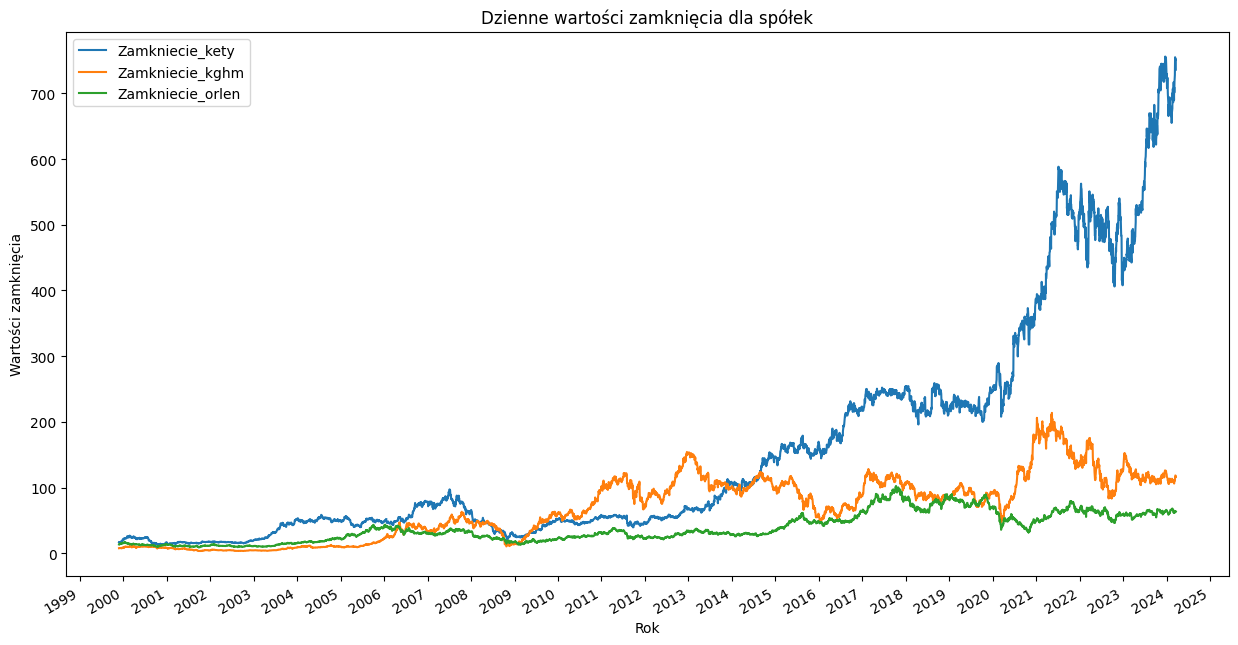

In [3]:
# Załóżmy, że 'merged_df' to DataFrame, który zawiera scalone dane
# Przekształca typ kolumny 'Data' na datetime
merged_df['Data'] = pd.to_datetime(merged_df['Data'])

# Ustaw kolumnę 'Data' jako indeks
merged_df.set_index('Data', inplace=True)

# Tworzenie wykresu
plt.figure(figsize=(15, 8))  # Dostosuj rozmiar wykresu według potrzeb

# Iteracja przez kolumny DataFrame i dodawanie każdej serii do wykresu
for column in merged_df.columns:
    if 'Zamkniecie' in column:  # Filtruj kolumny zawierające słowo 'Zamkniecie'
        plt.plot(merged_df.index, merged_df[column], label=column)

# Formatowanie osi X, aby pokazywała tylko lata
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Obrócenie etykiet na osi X dla lepszej czytelności
plt.gcf().autofmt_xdate()

# Dodawanie legendy, tytułu i etykiet osi
plt.legend()
plt.title('Dzienne wartości zamknięcia dla spółek')
plt.xlabel('Rok')
plt.ylabel('Wartości zamknięcia')

# Wyświetlenie wykresu
plt.show()

Przygotowanie danych do uzyskania podstawowych metryk

In [4]:
# Obliczenie dziennych zwrotów
daily_returns = merged_df.pct_change()

# Obliczenie oczekiwanego rocznego zwrotu
annual_returns = daily_returns.mean() * 252

# Obliczenie rocznej zmienności
annual_volatility = daily_returns.std() * np.sqrt(252)

# Obliczenie macierzy korelacji
correlation_matrix = daily_returns.corr()

C:\Users\Ania\AppData\Local\Temp\ipykernel_10068\2591088351.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = merged_df.pct_change()


## Mapa cieplna korelacji

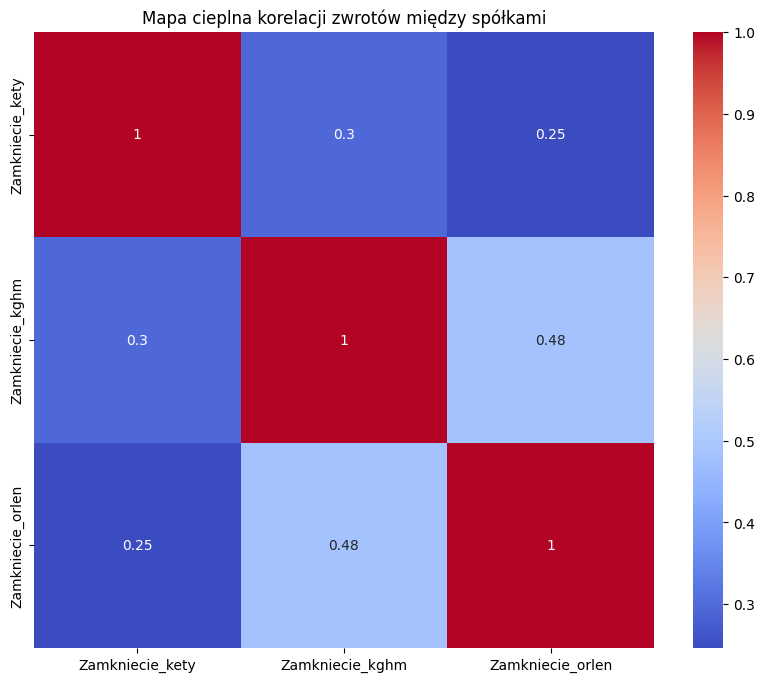

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa cieplna korelacji zwrotów między spółkami')
plt.show()

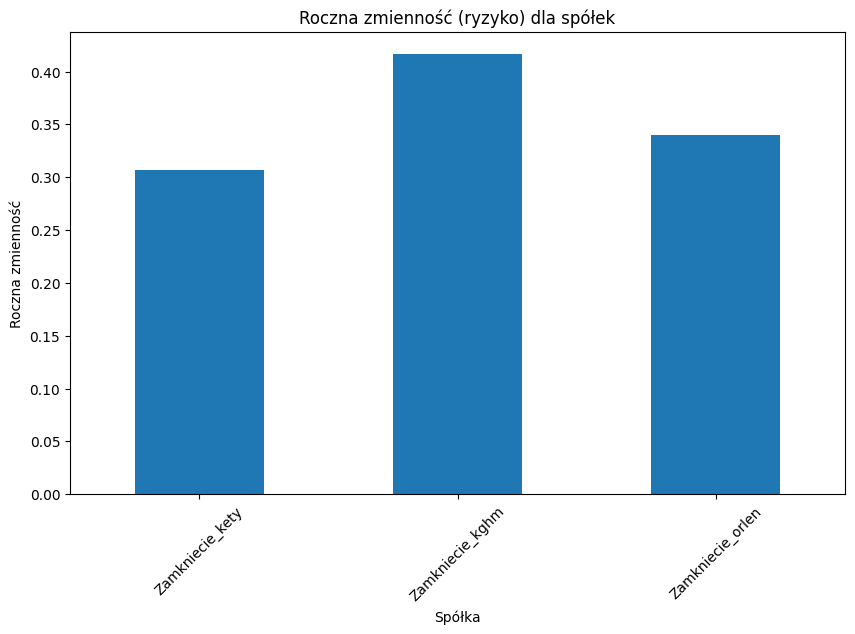

In [6]:
plt.figure(figsize=(10, 6))

# Rysowanie wykresu słupkowego rocznej zmienności dla każdej spółki
annual_volatility.plot(kind='bar')

plt.title('Roczna zmienność (ryzyko) dla spółek')
plt.xlabel('Spółka')
plt.ylabel('Roczna zmienność')
plt.xticks(rotation=45)
plt.show()

## Wykres skrzypcowy

Wykres prezentuje nałozone na siebie serie czasowe dziennej korekty ceny zamkniecia dla podanych spółek. Na osi X znajduje sie czas a na osi Y zmiany wartosci

C:\Users\Ania\AppData\Local\Temp\ipykernel_10068\559713328.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = merged_df.pct_change()


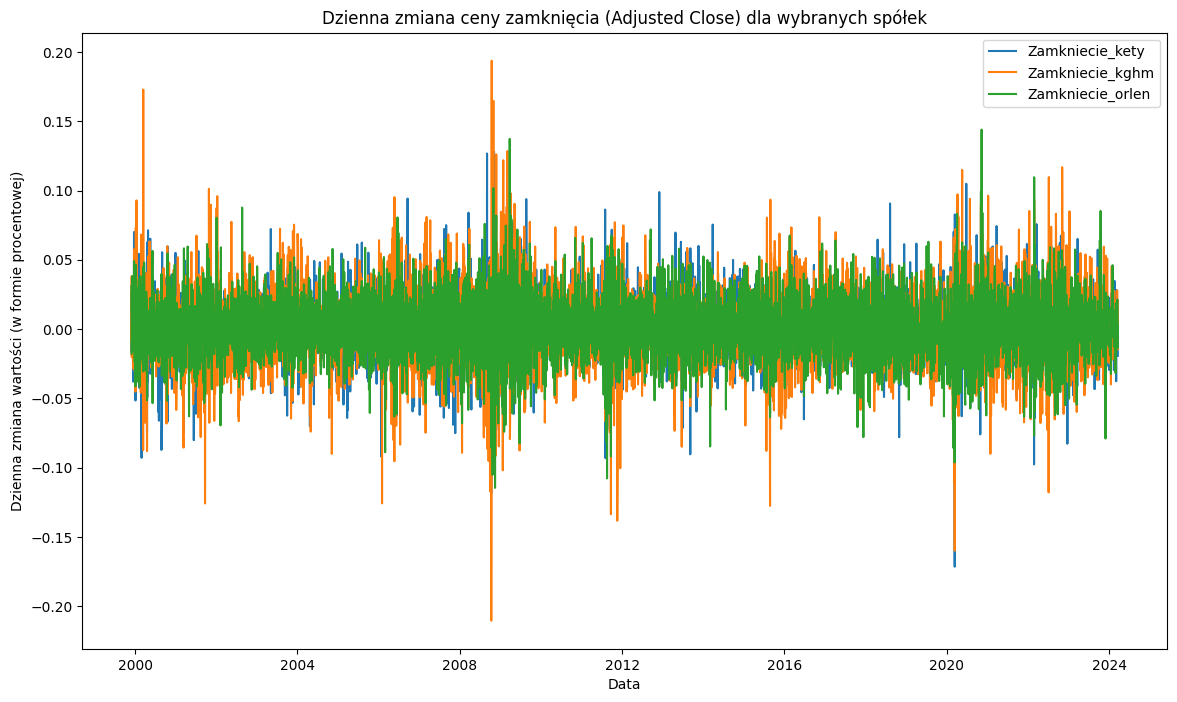

In [7]:
# Wyznaczanie zwrotów dziennych
daily_returns = merged_df.pct_change()

# Tworzenie wykresu
plt.figure(figsize=(14, 8))

# Rysowanie serii czasowych dla każdej kolumny
for column in daily_returns:
    plt.plot(daily_returns.index, daily_returns[column], label=column)

# Dodanie legendy, tytułu i etykiet osi
plt.legend()
plt.title('Dzienna zmiana ceny zamknięcia (Adjusted Close) dla wybranych spółek')
plt.xlabel('Data')
plt.ylabel('Dzienna zmiana wartości (w formie procentowej)')

# Wyświetlenie wykresu
plt.show()

## Metryki na podstawie podanych wykresów historycznych spółek

Na tym etapie dzięki wykorzystaniu losowych wag dla kazdego aktywa zasymulujemy składowe naszego portfolio w celu obliczenia metryk:

- **Normalizowane Wagi:** Pozwalają na proporcjonalne rozdzielenie kapitału między aktywa w portfelu, tak aby suma wag równała się 1. To klucz do kontroli dywersyfikacji i ekspozycji na poszczególne inwestycje.
- **Oczekiwany Zwrot Portfela:** Ważona suma oczekiwanych zwrotów z aktywów, odpowiadająca średniemu zwrotowi, jakiego inwestor może oczekiwać. Jest głównym wskaźnikiem potencjalnej efektywności inwestycji.
- **Oczekiwana Zmienność (Ryzyko) Portfela:** Mierzy ryzyko portfela jako standardowe odchylenie zwrotów, wskazując na możliwość odchylenia faktycznych zwrotów od oczekiwanych. Zależy od zmienności aktywów i ich korelacji.
- **Współczynnik Sharpe'a:** Ocena, czy wyższy zwrot z inwestycji jest adekwatny do ponoszonego ryzyka, poprzez porównanie nadwyżki zwrotu nad stopę bezryzykowną do zmienności portfela. Wysoka wartość wskazuje na atrakcyjny zwrot względem ryzyka.

Te elementy są fundamentem zarządzania portfelem, pozwalając inwestorom na budowanie i ocenę portfeli zgodnie z ich celami i tolerancją na ryzyko.

In [8]:
np.random.seed(1)

# Ustal liczbę spółek na podstawie liczby kolumn w merged_df, które zawierają słowo 'Zamkniecie'
num_assets = len([col for col in merged_df.columns if 'Zamkniecie' in col])

# Wygeneruj wagi dla każdego aktywa
weights = np.random.random(num_assets)
weights /= np.sum(weights)
print(f'Normalized Weights: {weights}')

# Oblicz dzienny logarytmiczny zwrot
log_ret = np.log(merged_df / merged_df.shift(1))

# Oblicz oczekiwany zwrot portfela
exp_ret = np.sum(log_ret.mean() * weights) * 252
print(f'\nOczekiwany zwrot portfela: {exp_ret}')

# Oblicz oczekiwaną zmienność (ryzyko) portfela
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
print(f'\nEkspozycja na ryzyko portfela: {exp_vol}')

# Oblicz współczynnik Sharpe'a
sharpe_ratio = exp_ret / exp_vol
print(f'\nWspólczynnik Sharpe: {sharpe_ratio}')

Normalized Weights: [3.66625362e-01 6.33274085e-01 1.00552749e-04]

Oczekiwany zwrot portfela: 0.1301407404790332

Ekspozycja na ryzyko portfela: 0.31654769971984176

Wspólczynnik Sharpe: 0.4111252130222817


### Co oznacza normalizowanie wag?

Normalizowane wagi w kontekście portfela akcji symulują, jak kapitał jest rozdzielony między różne akcje (czyli aktywa) w Twoim portfelu. Każda waga odpowiada procentowej części całkowitego kapitału zainwestowanego w daną akcję. Przykładowo, jeśli masz w portfelu akcje czterech spółek z wagami [0.4,0.3,0.2,0.1] oznacza to, że 40% Twojego kapitału jest zainwestowane w pierwszą spółkę, 30% w drugą, 20% w trzecią, a 10% w czwartą.

## Symulacja Monte Carlo

Symulacja Monte Carlo jest techniką używaną do zrozumienia wpływu ryzyka i niepewności w prognozowaniu modeli finansowych. Zakładając, że dysponujemy historycznymi dziennymi zwrotami, możemy przeprowadzić symulację Monte Carlo, aby wygenerować wiele potencjalnych przyszłych ścieżek cenowych dla akcji.

Ponizszy kod:
1. Obliczane są logarytmiczne zwroty dziennie, ponieważ są one czasami stabilniejsze i bardziej normalnie rozłożone, co jest przydatne w symulacji.
2. Ustalamy liczbę symulacji (num_simulations) i liczbę dni do przodu (num_days), na które chcemy przeprowadzić symulację.
3. Wykorzystujemy ostatnią dostępną cenę (last_price) jako punkt wyjścia dla naszej symulacji.
4. Dla każdej symulacji generujemy nową ścieżkę cenową, stosując wzór na random walk z dryfem, gdzie mean_daily_return to oczekiwany zwrot, a sigma * np.random.normal() to losowe zaburzenie odpowiadające za zmienność.
5. Na koniec rysujemy wyniki symulacji, prezentując możliwe ścieżki cen akcji na przestrzeni określonej liczby dni.

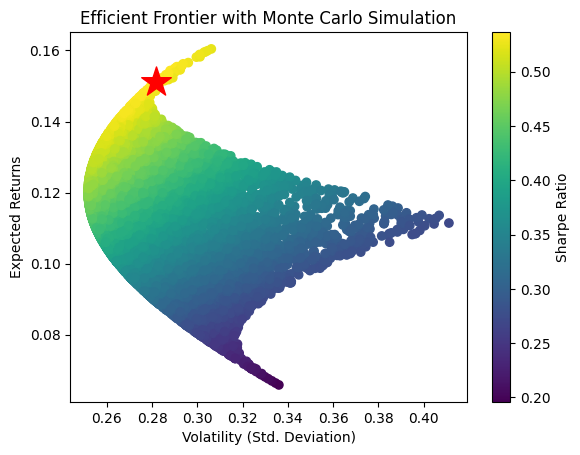


Skład portfela z najwyższym współczynnikiem Sharpe'a (Metoda Monte Carlo):
kety: 82.93%
kghm: 14.16%
orlen: 2.90%

Oczekiwany zwrot: 15.11%
Zmienność: 28.16%
Współczynnik Sharpe: 0.5364


In [9]:
# Ustawienie ziarna losowości dla powtarzalności wyników
np.random.seed(42)

# Liczba symulowanych portfeli
num_portfolios = 10000
num_stocks = merged_df.shape[1]

# Obliczenie logarytmicznych zwrotów
log_returns = np.log(merged_df / merged_df.shift(1))

# Puste listy do zapisywania wyników symulacji
portfolio_returns = []
portfolio_volatility = []
sharpe_ratio = []
stock_weights = []

# Symulowanie portfeli
for _ in range(num_portfolios):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    returns = np.dot(weights, log_returns.mean()) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sr = returns / volatility
    portfolio_returns.append(returns)
    portfolio_volatility.append(volatility)
    sharpe_ratio.append(sr)
    stock_weights.append(weights)

# Konwersja do DataFrame
portfolio_data = pd.DataFrame(data={
    'Returns': portfolio_returns,
    'Volatility': portfolio_volatility,
    'Sharpe Ratio': sharpe_ratio
})

# Dodanie wag akcji do DataFrame
for counter, symbol in enumerate(merged_df.columns.tolist()):
    portfolio_data[symbol + ' Weight'] = [w[counter] for w in stock_weights]

# Znalezienie portfela z największym współczynnikiem Sharpe'a
max_sharpe_port_monte_carlo = portfolio_data.iloc[portfolio_data['Sharpe Ratio'].idxmax()]

# Rysowanie wykresu efektywności portfela
plt.scatter(portfolio_data['Volatility'], portfolio_data['Returns'], c=portfolio_data['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier with Monte Carlo Simulation')

# Zaznaczenie portfela z maksymalnym współczynnikiem Sharpe'a
plt.scatter(max_sharpe_port_monte_carlo['Volatility'], max_sharpe_port_monte_carlo['Returns'], color='r', marker='*', s=500)
plt.show()

# Dynamiczne wyodrębnianie nazw spółek z nazw kolumn DataFrame 'merged_df', pomijając kolumnę 'Data'
companies = [col.replace('Zamkniecie_', '') for col in merged_df.columns if 'Zamkniecie' in col]

# Pobieranie wag dla portfela z najwyższym współczynnikiem Sharpe'a
optimal_weights_mc = max_sharpe_port_monte_carlo[[col for col in portfolio_data.columns if 'Weight' in col]].values

# Tworzenie i wyświetlanie opisu składu portfela
print("\nSkład portfela z najwyższym współczynnikiem Sharpe'a (Metoda Monte Carlo):")
for i, weight in enumerate(optimal_weights_mc.flatten()):  # Użycie .flatten(), aby przekształcić jednowymiarową tablicę numpy
    print(f"{companies[i]}: {weight * 100:.2f}%")

# Dodatkowo wyświetlamy podsumowanie portfela
print(f"\nOczekiwany zwrot: {max_sharpe_port_monte_carlo['Returns'] * 100:.2f}%")
print(f"Zmienność: {max_sharpe_port_monte_carlo['Volatility'] * 100:.2f}%")
print(f"Współczynnik Sharpe: {max_sharpe_port_monte_carlo['Sharpe Ratio']:.4f}")


Opis wykresu

Wykres, który widzisz, to graficzna reprezentacja tzw. "efektywnej granicy" (ang. Efficient Frontier) wraz z wynikami symulacji Monte Carlo dla portfela inwestycyjnego. Oto kluczowe punkty tego wykresu:

- **Oś pozioma (X):** Reprezentuje zmienność (standardowe odchylenie) zwrotów portfela. Jest to miara ryzyka; im wyższa wartość, tym wyższe ryzyko.
- **Oś pionowa (Y):** Wskazuje na oczekiwany zwrot portfela. Wyższe wartości na tej osi odpowiadają większym oczekiwanym zwrotom.
- **Kolorowe punkty:** Każdy punkt na wykresie reprezentuje potencjalny portfel z różnym zestawieniem aktywów. Kolory punktów mogą odpowiadać współczynnikowi Sharpe'a, który mierzy stosunek oczekiwanego zwrotu do ryzyka; wyższe wartości (żółte i zielone kolory) wskazują na lepszy stosunek zwrotu do ryzyka.
- **Gwiazda:** Zazwyczaj wyróżniony punkt, jak gwiazda lub inny marker, reprezentuje portfel o najwyższym współczynniku Sharpe'a, czyli taki, który oferuje najlepszy stosunek oczekiwanego zwrotu do ryzyka spośród wszystkich symulowanych portfeli.
- **Gradient kolorów:** Przypuszczalnie reprezentuje skalę wartości współczynnika Sharpe'a, gdzie ciemniejsze odcienie wskazują na niższe wartości współczynnika Sharpe'a, a jaśniejsze - na wyższe.

## Optymalizacja za pomocą kryterium maksymalizacji współczynnika Sharpe

Optymalny skład portfela inwestycyjnego można określić, stosując optymalizację według kryterium maksymalizacji współczynnika Sharpe'a. Optymalizacja ta często wykorzystuje metody numeryczne, takie jak optymalizatory gradientowe lub algorytmy genetyczne. W naszym wypadku wykorzystany funkcje `minimize` z biblioteki `scipy.optimize`

In [10]:
# 1. Definicja funkcji negatywnego współczynnika Sharpe'a
def neg_sharpe_ratio(weights):
    returns = np.dot(weights, log_returns.mean()) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sr = returns / volatility
    return -sr  # Zwracamy negatywną wartość, aby móc ją zminimalizować

# 2. Definicja ograniczeń i zakresu dla wag
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(num_stocks))

# 3. Użycie funkcji minimize do optymalizacji wag portfela
initial_weights = np.array(num_stocks * [1. / num_stocks])  # Początkowe równomierne rozłożenie wag
opt_results = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Optymalne wagi
opt_weights = opt_results.x

# Obliczenie wyników dla optymalnego portfela
opt_return = np.dot(opt_weights, log_returns.mean()) * 252
opt_volatility = np.sqrt(np.dot(opt_weights.T, np.dot(log_returns.cov() * 252, opt_weights)))
opt_sharpe_ratio = opt_return / opt_volatility



# Dynamiczne wyodrębnianie nazw spółek z nazw kolumn DataFrame 'merged_df', pomijając kolumnę 'Data'
companies = [col.replace('Zamkniecie_', '') for col in merged_df.columns if 'Zamkniecie' in col]

# Tworzenie opisu składu portfela
portfolio_description = "\nSkład portfela: "
for i, weight in enumerate(opt_weights):
    # Dla każdej spółki dodajemy jej nazwę i przypisaną wagę do opisu
    portfolio_description += f"\n{companies[i]}: {weight * 100:.2f}% "



print("\nOptymalny portfel z wykorzystaniem kryterium maksymalizacji współczynnika Sharpe'a")
# Wyświetlenie opisu portfela
print(portfolio_description)
print(f"\nOczekiwany zwrot: {opt_return*100:.2f}% \nZmienność: {opt_volatility*100:.2f}% \nWspółczynnik Sharpe: {opt_sharpe_ratio:.4f}")

print("\n=================\n")

# Porównanie z wynikami metody Monte Carlo
# Tworzenie i wyświetlanie opisu składu portfela
print("Skład portfela z najwyższym współczynnikiem Sharpe'a (Metoda Monte Carlo):")
print("\nSkład portfela: ")
for i, weight in enumerate(optimal_weights_mc.flatten()):  # Użycie .flatten(), aby przekształcić jednowymiarową tablicę numpy
    print(f"{companies[i]}: {weight * 100:.2f}%")

# Dodatkowo wyświetlamy podsumowanie portfela
print(f"\nOczekiwany zwrot: {max_sharpe_port_monte_carlo['Returns'] * 100:.2f}%")
print(f"Zmienność: {max_sharpe_port_monte_carlo['Volatility'] * 100:.2f}%")
print(f"Współczynnik Sharpe: {max_sharpe_port_monte_carlo['Sharpe Ratio']:.4f}")



Optymalny portfel z wykorzystaniem kryterium maksymalizacji współczynnika Sharpe'a

Skład portfela: 
kety: 83.18% 
kghm: 14.98% 
orlen: 1.84% 

Oczekiwany zwrot: 15.17% 
Zmienność: 28.28% 
Współczynnik Sharpe: 0.5365


Skład portfela z najwyższym współczynnikiem Sharpe'a (Metoda Monte Carlo):

Skład portfela: 
kety: 82.93%
kghm: 14.16%
orlen: 2.90%

Oczekiwany zwrot: 15.11%
Zmienność: 28.16%
Współczynnik Sharpe: 0.5364
